# Jordan O'Donovan - x19372016@student.ncirl.ie

In [25]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import transformers
from sklearn import metrics
from sklearn.cluster import KMeans

bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', truncation=True)
model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Amazon

In [ ]:
df = pd.read_csv("Data/amazon_books.csv", nrows=30000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  30000 non-null  object 
 1   Title               29999 non-null  object 
 2   Price               4105 non-null   float64
 3   User_id             24079 non-null  object 
 4   profileName         24078 non-null  object 
 5   review/helpfulness  30000 non-null  object 
 6   review/score        30000 non-null  float64
 7   review/time         30000 non-null  int64  
 8   review/summary      30000 non-null  object 
 9   review/text         30000 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.3+ MB


In [ ]:
# Encoding Titles
labels = {}
x = 0
y = 0
for index, row in df.iterrows():
    
    if not df.Title[x] in labels:
        labels[df.Title[x]] = y
        y += 1
    x += 1
len(labels)

df['title_id'] = df['Title'].map(labels)

In [ ]:
df

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,title_id
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,0
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,1
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",1
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",1
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,0140860096,Of Mice and Men (Penguin Audiobooks),NaN,A2CYWFT3GEB7OV,"""chonita_15""",2/3,5.0,966384000,"The Perfect book, &quot;Of Mice and Men&quot;",Mr. Steinbeck has created a masterpiece. Short...,2239
29996,0140860096,Of Mice and Men (Penguin Audiobooks),NaN,A2KFDT3ENO7N21,kae,2/3,3.0,965174400,Recomendation,Of Mice and men is a book that I first raed fo...,2239
29997,0140860096,Of Mice and Men (Penguin Audiobooks),NaN,NaN,NaN,2/3,5.0,951350400,Of Mice and Men,Of Mice and Men is a book about two men who ha...,2239
29998,0140860096,Of Mice and Men (Penguin Audiobooks),NaN,A11NMT4P8EPWKW,"""mambodog""",2/3,5.0,944092800,A Bantamweight word user. A Heavyweight storyt...,"This is old school writing, writing from befor...",2239


In [ ]:
#df['title_id'] =df.Title.astype('category').cat.codes
df.User_id = df.User_id.astype('category').cat.codes

In [ ]:
df = df.set_axis(['id', 'title', 'price', 'user', 'profile_name', 'helpfulness', 'rating', 'time', 
                 'summary', 'review', 'title_id'], axis=1, copy=False)

In [ ]:
df.isna().sum()

id                  0
title               1
price           25895
user                0
profile_name     5922
helpfulness         0
rating              0
time                0
summary             0
review              0
title_id            0
dtype: int64

In [ ]:
df = df[df['user']!= -1]

In [ ]:
df.isna().sum()

id                  0
title               1
price           20598
user                0
profile_name        1
helpfulness         0
rating              0
time                0
summary             0
review              0
title_id            0
dtype: int64

In [ ]:
df.shape

(24079, 11)

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.head()

,id,title,price,user,profile_name,helpfulness,rating,time,summary,review,title_id
0,1882931173,Its Only Art If Its Well Hung!,NaN,20050,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...,0
1,0826414346,Dr. Seuss: American Icon,NaN,10956,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...,1
2,0826414346,Dr. Seuss: American Icon,NaN,15530,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t...",1
3,0826414346,Dr. Seuss: American Icon,NaN,8840,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",1
4,0826414346,Dr. Seuss: American Icon,NaN,5825,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...,1


In [ ]:
df = df.drop_duplicates(subset=['profile_name', 'title'])

# BERT

In [ ]:
# Clean the reviews first

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
df_bert = df.loc[:, ['id', 'title', 'title_id', 'user', 'review']]

In [ ]:
df_bert

,id,title,title_id,user,review
0,1882931173,Its Only Art If Its Well Hung!,0,20050,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,1,10956,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,1,15530,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,1,8840,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,1,5825,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...
24073,0140860096,Of Mice and Men (Penguin Audiobooks),2239,5924,John Steinbeck's book is a definite future cla...
24074,0140860096,Of Mice and Men (Penguin Audiobooks),2239,14567,Of Mice and Men captures a part of American Hi...
24075,0140860096,Of Mice and Men (Penguin Audiobooks),2239,4811,John Steinbeck had always been associated with...
24076,0140860096,Of Mice and Men (Penguin Audiobooks),2239,7346,Mr. Steinbeck has created a masterpiece. Short...


In [ ]:
df_bert.review[3]

"Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, children and their parents will still eagerly read the books of a fellow called Ted Geisel, popularly known as Dr. Seuss.&quot;Flesch was too conservative in his prediction. A century, and more, from today, Dr. Seuss will still be read when many authors on today's bestseller lists will be forgotten.Published on the centenary of Geisel's birth, Dr. Seuss: American Icon analyzes six key aspects of Seuss's career: poetry, politics, art, biography, marketing, and influence.In six insightful chapters, Philip Nel, Assistant Professor of English at Kansas State University, discusses &quot;U.S. Laureate of Nonsense,&quot; &quot;Dr. Seuss vs. Adolf Hitler,&quot; &quot;The Doc in the Smock,&quot; &quot;The 5,000 Fingers of Dr. S.,&quot; &quot;The Disneyfication of Dr. Seuss,&quot; and &quot;The Cat in 

In [ ]:
df_bert = df_bert.replace('&quot', '', regex=True)

In [ ]:
def clean_text(x):
    x = re.sub(r'[^\w\s]', ' ', str(x).lower().strip())

    x = re.sub(r'\s+', ' ', x)

    x = nltk.word_tokenize(x)

    x = [word for word in x if word not in stopwords]


    lem = nltk.stem.wordnet.WordNetLemmatizer()
    x = [lem.lemmatize(token) for token in x]
    
    return " ".join(x)

df_bert['cleaned_review'] = df_bert['review'].apply(lambda x: clean_text(x))

In [ ]:
df_bert.to_csv('Data/amazon_books_cleaned.csv', index=False)

In [ ]:
df_bert = pd.read_csv('Data/amazon_books_cleaned.csv')

In [ ]:
df_bert

,id,title,title_id,user,review
0,1882931173,Its Only Art If Its Well Hung!,0,20050,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,1,10956,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,1,15530,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,1,8840,"Theodore Seuss Geisel (1904-1991), aka ;Dr. Se..."
4,0826414346,Dr. Seuss: American Icon,1,5825,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...
22993,0140860096,Of Mice and Men (Penguin Audiobooks),2239,5924,John Steinbeck's book is a definite future cla...
22994,0140860096,Of Mice and Men (Penguin Audiobooks),2239,14567,Of Mice and Men captures a part of American Hi...
22995,0140860096,Of Mice and Men (Penguin Audiobooks),2239,4811,John Steinbeck had always been associated with...
22996,0140860096,Of Mice and Men (Penguin Audiobooks),2239,7346,Mr. Steinbeck has created a masterpiece. Short...


df_bert[df_bert['cleaned_review'].isna()]

df_bert = df_bert.dropna(subset='cleaned_review')

In [ ]:
df_bert

,id,title,title_id,user,review
0,1882931173,Its Only Art If Its Well Hung!,0,20050,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,1,10956,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,1,15530,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,1,8840,"Theodore Seuss Geisel (1904-1991), aka ;Dr. Se..."
4,0826414346,Dr. Seuss: American Icon,1,5825,Philip Nel - Dr. Seuss: American IconThis is b...
...,...,...,...,...,...
22993,0140860096,Of Mice and Men (Penguin Audiobooks),2239,5924,John Steinbeck's book is a definite future cla...
22994,0140860096,Of Mice and Men (Penguin Audiobooks),2239,14567,Of Mice and Men captures a part of American Hi...
22995,0140860096,Of Mice and Men (Penguin Audiobooks),2239,4811,John Steinbeck had always been associated with...
22996,0140860096,Of Mice and Men (Penguin Audiobooks),2239,7346,Mr. Steinbeck has created a masterpiece. Short...


In [ ]:
df_bert = df_bert[0:10000]

In [ ]:
df_bert['review_tokens'] = df_bert['review'].apply(lambda x: bert_tokenizer.tokenize(x))

C:\Users\odono\AppData\Local\Temp\ipykernel_3644\1928057615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bert['review_tokens'] = df_bert['review'].apply(lambda x: bert_tokenizer.tokenize(x))


In [ ]:
# CSV is now 73.4MB
df_bert.to_csv('Data/amazon_books_cleaned.csv', index=False)

In [ ]:
df_bert = pd.read_csv('amazon_books_cleaned.csv')

In [ ]:
df_bert

,id,title,title_id,user,review,review_tokens
0,1882931173,Its Only Art If Its Well Hung!,0,20050,This is only for Julie Strain fans. It's a col...,"['this', 'is', 'only', 'for', 'julie', 'strain..."
1,0826414346,Dr. Seuss: American Icon,1,10956,I don't care much for Dr. Seuss but after read...,"['i', 'don', ""'"", 't', 'care', 'much', 'for', ..."
2,0826414346,Dr. Seuss: American Icon,1,15530,"If people become the books they read and if ""t...","['if', 'people', 'become', 'the', 'books', 'th..."
3,0826414346,Dr. Seuss: American Icon,1,8840,"Theodore Seuss Geisel (1904-1991), aka ;Dr. Se...","['theodore', 'se', '##uss', 'ge', '##ise', '##..."
4,0826414346,Dr. Seuss: American Icon,1,5825,Philip Nel - Dr. Seuss: American IconThis is b...,"['philip', 'ne', '##l', '-', 'dr', '.', 'se', ..."
...,...,...,...,...,...,...
9995,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,13397,"I found her concept very, VERY good, BUT, unle...","['i', 'found', 'her', 'concept', 'very', ',', ..."
9996,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,18499,I purchased this book thinking it would tell a...,"['i', 'purchased', 'this', 'book', 'thinking',..."
9997,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,8086,it was and still has been very helpful to know...,"['it', 'was', 'and', 'still', 'has', 'been', '..."
9998,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,7062,"Amazon has in stock, ready to ship, the 2006, ...","['amazon', 'has', 'in', 'stock', ',', 'ready',..."


In [ ]:
test = ['this', 'is', 'only', 'for', 'julie', 'strain', 'fans', '.', 'it', "'", 's', 'a', 'collection', 'of', 'her', 'photos', '-', '-', 'about', '80', 'pages', 'worth', 'with', 'a', 'nice', 'section', 'of', 'paintings', 'by', 'olivia', '.', 'if', 'you', "'", 're', 'looking', 'for', 'heavy', 'literary', 'content', ',', 'this', 'isn', "'", 't', 'the', 'place', 'to', 'find', 'it', '-', '-', 'there', "'", 's', 'only', 'about', '2', 'pages', 'with', 'text', 'and', 'everything', 'else', 'is', 'photos', '.', 'bottom', 'line', ':', 'if', 'you', 'only', 'want', 'one', 'book', ',', 'the', 'six', 'foot', 'one', '.', '.', '.', 'is', 'probably', 'a', 'better', 'choice', ',', 'however', ',', 'if', 'you', 'like', 'julie', 'like', 'i', 'like', 'julie', ',', 'you', 'won', "'", 't', 'go', 'wrong', 'on', 'this', 'one', 'either', '.']

In [ ]:
bert_tokenizer.convert_tokens_to_ids(test)

[2023,
 2003,
 2069,
 2005,
 7628,
 10178,
 4599,
 1012,
 2009,
 1005,
 1055,
 1037,
 3074,
 1997,
 2014,
 7760,
 1011,
 1011,
 2055,
 3770,
 5530,
 4276,
 2007,
 1037,
 3835,
 2930,
 1997,
 5265,
 2011,
 7710,
 1012,
 2065,
 2017,
 1005,
 2128,
 2559,
 2005,
 3082,
 4706,
 4180,
 1010,
 2023,
 3475,
 1005,
 1056,
 1996,
 2173,
 2000,
 2424,
 2009,
 1011,
 1011,
 2045,
 1005,
 1055,
 2069,
 2055,
 1016,
 5530,
 2007,
 3793,
 1998,
 2673,
 2842,
 2003,
 7760,
 1012,
 3953,
 2240,
 1024,
 2065,
 2017,
 2069,
 2215,
 2028,
 2338,
 1010,
 1996,
 2416,
 3329,
 2028,
 1012,
 1012,
 1012,
 2003,
 2763,
 1037,
 2488,
 3601,
 1010,
 2174,
 1010,
 2065,
 2017,
 2066,
 7628,
 2066,
 1045,
 2066,
 7628,
 1010,
 2017,
 2180,
 1005,
 1056,
 2175,
 3308,
 2006,
 2023,
 2028,
 2593,
 1012]

In [ ]:
bert_tokenizer.encode_plus(test)

{'input_ids': [101, 2023, 2003, 2069, 2005, 7628, 10178, 4599, 1012, 2009, 1005, 1055, 1037, 3074, 1997, 2014, 7760, 1011, 1011, 2055, 3770, 5530, 4276, 2007, 1037, 3835, 2930, 1997, 5265, 2011, 7710, 1012, 2065, 2017, 1005, 2128, 2559, 2005, 3082, 4706, 4180, 1010, 2023, 3475, 1005, 1056, 1996, 2173, 2000, 2424, 2009, 1011, 1011, 2045, 1005, 1055, 2069, 2055, 1016, 5530, 2007, 3793, 1998, 2673, 2842, 2003, 7760, 1012, 3953, 2240, 1024, 2065, 2017, 2069, 2215, 2028, 2338, 1010, 1996, 2416, 3329, 2028, 1012, 1012, 1012, 2003, 2763, 1037, 2488, 3601, 1010, 2174, 1010, 2065, 2017, 2066, 7628, 2066, 1045, 2066, 7628, 1010, 2017, 2180, 1005, 1056, 2175, 3308, 2006, 2023, 2028, 2593, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import ast

df_bert['review_tokens'] = df_bert['review_tokens'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Creating my inputs for the neural network
x = 0

encode_ids =[]
mask_ids = []
segment_ids = []

for review in df_bert['review_tokens']:
    #print(type(review))
    #review = ast.literal_eval(review)
    #print(type(review))
    
    #print(review)
    encoding = bert_tokenizer.encode_plus(review, truncation=True)
    
    #print(encoding['input_ids'][1:-1])
    
    encode_ids.append(encoding['input_ids'][1:-1])
    mask_ids.append(encoding['attention_mask'])
    segment_ids.append(encoding['token_type_ids'])
    
    x += 1
    
    if x % 1000 == 0:
        print(f"Percent done: {round(x/df_bert.shape[0]*100,2)}%")

Percent done: 10.0%
Percent done: 20.0%
Percent done: 30.0%
Percent done: 40.0%
Percent done: 50.0%
Percent done: 60.0%
Percent done: 70.0%
Percent done: 80.0%
Percent done: 90.0%
Percent done: 100.0%


In [ ]:
# Padding so theyre all the same length
max_len = max(len(x) for x in segment_ids)
padded_encode_ids = []
padded_mask_ids = []
padded_segment_ids = []

for i, review in enumerate(encode_ids):
    review = review + [0] * (max_len - len(review))
    padded_encode_ids.append(review)
    
max_len = max(len(x) for x in mask_ids)
    
for i, review in enumerate(mask_ids):
    review = review + [0] * (max_len - len(review))
    padded_mask_ids.append(review)  
    
max_len = max(len(x) for x in segment_ids)
    
for i, review in enumerate(segment_ids):
    review = review + [0] * (max_len - len(review))
    padded_segment_ids.append(review) 


In [ ]:
# Creating tensorflow constants to use as inputs
encode_ids = tf.constant(padded_encode_ids)
mask_ids = tf.constant(padded_mask_ids)
segment_ids = tf.constant(padded_segment_ids)

In [ ]:
segment_ids.shape

TensorShape([10000, 512])

In [ ]:
batch_size = 400

encode_ids2 = encode_ids[:batch_size, :]
mask_ids2 = mask_ids[:batch_size, :]
segment_ids2 = segment_ids[:batch_size, :]

In [ ]:
# Original BERT model, laptop crashes after batch size > 350
embeddings = model(encode_ids2, mask_ids2, segment_ids2)

ResourceExhaustedError: Exception encountered when calling layer "self" "                 f"(type TFBertSelfAttention).

{{function_node __wrapped__RealDiv_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[400,12,512,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:RealDiv]

Call arguments received by layer "self" "                 f"(type TFBertSelfAttention):
  • hidden_states=tf.Tensor(shape=(400, 512, 768), dtype=float32)
  • attention_mask=tf.Tensor(shape=(400, 1, 1, 512), dtype=float32)
  • head_mask=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_value=None
  • output_attentions=False
  • training=False

In [ ]:
embeddings.last_hidden_state

In [ ]:
item_embeddings = embeddings.last_hidden_state

In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_bert2 = df_bert

In [ ]:
# Bert's maximum length is 512
df_bert2['review'] = df_bert2['review'].str[:512]

In [ ]:
# Creating BERT embeddings using PyTorch
z = 0
def convert_to_embedding(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    global z
    z += 1
    if z % 100 == 0:
        print(f"{round(z/df_bert2.shape[0]*100, 2)}% finished.")
    
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
    return last_hidden_states[0].numpy()

# Apply the function to each row of the 'text' column
df_bert2['embeddings'] = df_bert2['review'].apply(lambda x: convert_to_embedding(x))

1.0% finished.
2.0% finished.
3.0% finished.
4.0% finished.
5.0% finished.
6.0% finished.
7.0% finished.
8.0% finished.
9.0% finished.
10.0% finished.
11.0% finished.
12.0% finished.
13.0% finished.
14.0% finished.
15.0% finished.
16.0% finished.
17.0% finished.
18.0% finished.
19.0% finished.
20.0% finished.
21.0% finished.
22.0% finished.
23.0% finished.
24.0% finished.
25.0% finished.
26.0% finished.
27.0% finished.
28.0% finished.
29.0% finished.
30.0% finished.
31.0% finished.
32.0% finished.
33.0% finished.
34.0% finished.
35.0% finished.
36.0% finished.
37.0% finished.
38.0% finished.
39.0% finished.
40.0% finished.
41.0% finished.
42.0% finished.
43.0% finished.
44.0% finished.
45.0% finished.
46.0% finished.
47.0% finished.
48.0% finished.
49.0% finished.
50.0% finished.
51.0% finished.
52.0% finished.
53.0% finished.
54.0% finished.
55.0% finished.
56.0% finished.
57.0% finished.
58.0% finished.
59.0% finished.
60.0% finished.
61.0% finished.
62.0% finished.
63.0% finished.
6

In [ ]:
df_bert2.to_csv('amazon_books_cleaned_embeddings.csv', index=False)

In [ ]:
df_bert2 = pd.read_csv('amazon_books_cleaned_embeddings.csv')

In [ ]:
df_bert2

,id,title,title_id,user,review,review_tokens,embeddings
0,1882931173,Its Only Art If Its Well Hung!,0,20050,This is only for Julie Strain fans. It's a col...,"['this', 'is', 'only', 'for', 'julie', 'strain...",[[-0.05483561 -0.35395646 -0.09698626 ... 0.0...
1,0826414346,Dr. Seuss: American Icon,1,10956,I don't care much for Dr. Seuss but after read...,"['i', 'don', ""'"", 't', 'care', 'much', 'for', ...",[[ 0.10421317 -0.09112115 -0.27633506 ... 0.1...
2,0826414346,Dr. Seuss: American Icon,1,15530,"If people become the books they read and if ""t...","['if', 'people', 'become', 'the', 'books', 'th...",[[-0.10817145 -0.12313468 -0.33880794 ... -0.0...
3,0826414346,Dr. Seuss: American Icon,1,8840,"Theodore Seuss Geisel (1904-1991), aka ;Dr. Se...","['theodore', 'se', '##uss', 'ge', '##ise', '##...",[[-0.4777217 -0.05591106 -0.4990472 ... 0.0...
4,0826414346,Dr. Seuss: American Icon,1,5825,Philip Nel - Dr. Seuss: American IconThis is b...,"['philip', 'ne', '##l', '-', 'dr', '.', 'se', ...",[[-0.21444207 -0.33883682 -0.4606077 ... 0.0...
...,...,...,...,...,...,...,...
9995,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,13397,"I found her concept very, VERY good, BUT, unle...","['i', 'found', 'her', 'concept', 'very', ',', ...",[[ 0.26416805 -0.5397065 0.16540693 ... 0.0...
9996,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,18499,I purchased this book thinking it would tell a...,"['i', 'purchased', 'this', 'book', 'thinking',...",[[-0.09889867 -0.2528463 0.46130183 ... -0.2...
9997,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,8086,it was and still has been very helpful to know...,"['it', 'was', 'and', 'still', 'has', 'been', '...",[[ 0.1319696 -0.05093477 0.11608087 ... -0.1...
9998,0945760337,Lotto Winning Wheels for Powerball & Mega Mill...,1071,7062,"Amazon has in stock, ready to ship, the 2006, ...","['amazon', 'has', 'in', 'stock', ',', 'ready',...",[[-0.5558758 -0.3671625 0.5481298 ... -0.4...


In [ ]:
df_bert2.user.value_counts()

708      27
17643    17
17886    10
15868     7
1971      7
         ..
20333     1
14309     1
18507     1
5024      1
15291     1
Name: user, Length: 9414, dtype: int64

In [ ]:
pip install sentence_transformers

In [7]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
#Get Embeddings
sentence_embeddings = bert.encode(df_bert2['review'].tolist())

In [ ]:
#Compute similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(sentence_embeddings)

In [ ]:
def recommend_books(book_name, top_n=5):
    
    book_index = df_bert2[df_bert2['title'] == book_name].index[0]
    
    scores = list(enumerate(similarity[book_index]))
    
    # Sort the scores in descending order
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    top_n_indices = []
    i = 1
    # Stop the input book returning as a recommended book
    while len(top_n_indices) < top_n and i < len(scores):
        if df_bert2.iloc[scores[i][0]]['title'] != book_name:
            top_n_indices.append(scores[i][0])
        i += 1
    
    return df_bert2.iloc[top_n_indices]['title'].values

In [ ]:
book = "Economics in one lesson"
recommend_books(book)

array(['Professional collection catalog',
       'How to Own Your Home Years Sooner - without making extra interest payments',
       'The Forsythe Saga', 'The Dharma Bums', 'Dumb witness'],
      dtype=object)

In [ ]:
book = "Romeo and Juliet"
recommend_books(book)

array(["Prodigal Son (Dean Koontz's Frankenstein, Book 1)",
       'The Scarletti Curse (Candleglow)', 'Foundation', 'Foundation',
       'The Scarletti Curse (Candleglow)'], dtype=object)

In [ ]:
  book = "Dr. Bernstein's Diabetes Solution: The Complete Guide to Achieving Normal Blood Sugars Revised & Updated"
  recommend_books(book)

array(['Economics in one lesson',
       'The Gluten-Free Bible: The Thoroughly Indispensable Guide to Negotiating Life without Wheat',
       'The Gluten-Free Bible: The Thoroughly Indispensable Guide to Negotiating Life without Wheat',
       'Semi-Homemade Cooking: Quick, Marvelous Meals and Nothing is Made from scratch',
       'Neuropsychology of Weight Control: Personal Progress Journal'],
      dtype=object)

In [ ]:
book = "Stopped at Stalingrad: The Luftwaffe and Hitler's Defeat in the East, 1942-1943 (Modern War Studies)"
recommend_books(book)

array(['Crimson Skies: Aircraft Manual',
       "Lenin's Tomb: The Last Days of the Soviet Empire",
       'Dick Bong: Ace of Aces', 'The Birth of Britain volume One',
       'Homer or Moses?: Early Christian Interpretations of the History of Culture (Hermeneutische Untersuchungen zur Theologie)'],
      dtype=object)

In [ ]:
df_bert2.title.value_counts().head(40)

The Scarlet Letter A Romance                                                                                613
Foundation                                                                                                  407
Tess of the D'Urbervilles: A pure woman (Harper's modern classics)                                          314
Economics in one lesson                                                                                     309
Helter Skelter                                                                                              220
Prodigal Son (Dean Koontz's Frankenstein, Book 1)                                                           200
Romeo and Juliet                                                                                            190
The Dharma Bums                                                                                             160
Dr. Bernstein's Diabetes Solution: The Complete Guide to Achieving Normal Blood Sugars Revised & Updated

In [ ]:
# Creating clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(sentence_embeddings)
labels = kmeans.labels_

label_title_mapping = {}
for i, label in enumerate(labels):
    if label not in label_title_mapping:
        label_title_mapping[label] = []
    label_title_mapping[label].append(df_bert2['title'][i])


for label, titles in label_title_mapping.items():
    print(f'Cluster Label: {label}')
    print(f'Titles: {titles}')

Cluster Label: 4
Titles: ['Its Only Art If Its Well Hung!', 'Dr. Seuss: American Icon', 'Dr. Seuss: American Icon', 'Wonderful Worship in Smaller Churches', 'Wonderful Worship in Smaller Churches', 'Whispers of the Wicked Saints', 'Whispers of the Wicked Saints', 'Whispers of the Wicked Saints', 'The Church of Christ: A Biblical Ecclesiology for Today', 'Dramatica for Screenwriters', 'The Ultimate Guide to Law School Admission: Insider Secrets for Getting a "Big Envelope" with Your Acceptance to Law School!', 'The Ultimate Guide to Law School Admission: Insider Secrets for Getting a "Big Envelope" with Your Acceptance to Law School!', "Overcoming Hypertension (Dr. Kenneth H. Cooper's Preventive Medicine Program)", 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdough', 'Alaska Sourdoug

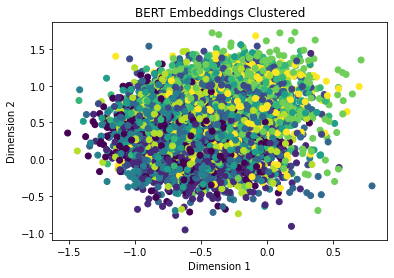

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(sentence_embeddings)

plt.scatter(sentence_embeddings[:,0], sentence_embeddings[:,1], c=kmeans.labels_)
plt.title("BERT Embeddings Clustered")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

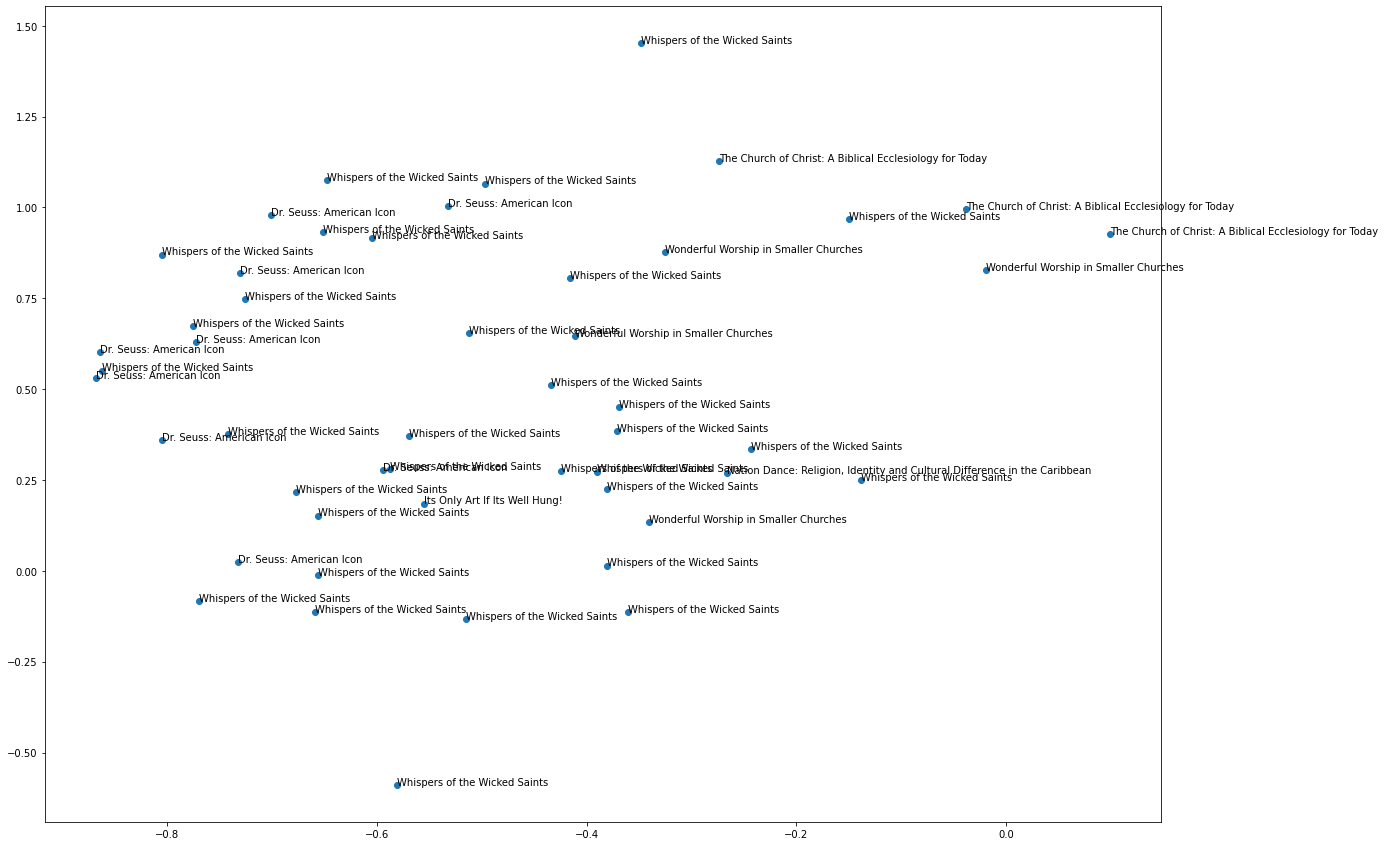

In [ ]:
# Showing how different reviews for the same book can be 
plt.figure(figsize=(20,15))

subset_sentence_embeddings = sentence_embeddings[:50]
subset_titles = df_bert2['title'][:50].tolist()

x = [se[0] for se in subset_sentence_embeddings]
y = [se[1] for se in subset_sentence_embeddings]

plt.scatter(x, y)

for i, title in enumerate(subset_titles):
    plt.annotate(title, (x[i], y[i]))

plt.show()

# Yelp


In [8]:
yelp = pd.read_csv("yelp.csv")

In [9]:
yelp.columns = ["sentiment", "review"]

In [10]:
yelp.isna().sum()

sentiment    94920
review       94920
dtype: int64

In [11]:
yelp = yelp[:99999]

In [12]:
yelp.shape

(99999, 2)

In [13]:
yelp.isna().sum()

sentiment    0
review       0
dtype: int64

In [14]:
yelp.sentiment.value_counts()

1.0    53196
2.0    46803
Name: sentiment, dtype: int64

In [15]:
yelp['sentiment_word'] = yelp['sentiment']

In [16]:
yelp['sentiment_word'] = yelp['sentiment_word'].replace(1, 'Negative')
yelp['sentiment_word'] = yelp['sentiment_word'].replace(2, 'Positive')

In [17]:
counts = [53196, 46803]
labels = ['Negative', 'Positive']

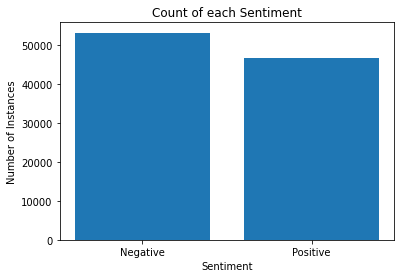

In [18]:
fig, ax = plt.subplots()
ax.bar(labels, counts)
plt.title("Count of each Sentiment")
plt.xlabel('Sentiment')
plt.ylabel("Number of Instances")
plt.show()

In [35]:
review_embeddings = bert.encode(yelp['review'].tolist())

In [36]:
review_embeddings

array([[-0.5237659 ,  0.80610025,  0.57531124, ...,  0.6028789 ,
         0.38829702,  0.07723187],
       [-0.29526466,  1.1659522 ,  0.38267294, ...,  0.32791898,
        -0.28809062,  0.3701962 ],
       [ 0.31083632,  0.7549368 ,  0.8639219 , ...,  0.7065573 ,
        -0.653062  ,  0.54003   ],
       ...,
       [-0.8582293 ,  1.3227267 ,  0.00317886, ...,  0.7054642 ,
         0.23497295, -0.08331835],
       [-0.46409148,  1.0201637 , -0.43114382, ...,  0.4107666 ,
         0.41648328,  0.11158802],
       [-0.09328921,  0.5279571 , -0.71246195, ...,  0.6977602 ,
         0.43214905,  0.03752781]], dtype=float32)

In [37]:
kmeans = KMeans(n_clusters=2).fit(review_embeddings)
yelp['prediction'] = kmeans.labels_

In [38]:
yelp

,sentiment,review,sentiment_word,cleaned_review,prediction
0,2.0,Been going to Dr. Goldberg for over 10 years. ...,Positive,going dr goldberg 10 year think one 1st patien...,0
1,1.0,I don't know what Dr. Goldberg was like before...,Negative,know dr goldberg like moving arizona let tell ...,1
2,1.0,I'm writing this review to give you a heads up...,Negative,writing review give head see doctor office sta...,1
3,2.0,All the food is great here. But the best thing...,Positive,food great best thing wing wing simply fantast...,0
4,1.0,Wing sauce is like water. Pretty much a lot of...,Negative,wing sauce like water pretty much lot butter h...,0
...,...,...,...,...,...
99994,2.0,After my final walk out of Quick Wok on Southe...,Positive,final walk quick wok southern stink decided tr...,1
99995,2.0,"Sadly, I went to pick up my yummy food last Fr...",Positive,sadly went pick yummy food last friday night s...,1
99996,1.0,Been going here since they open on the corner ...,Negative,going since open corner mcclintock east guadal...,0
99997,1.0,I was really excited to try out Tott's after h...,Negative,really excited try tott hearing many good thin...,1


In [39]:
yelp['prediction'] = yelp['prediction'].replace(0, 2)

In [40]:
yelp

,sentiment,review,sentiment_word,cleaned_review,prediction
0,2.0,Been going to Dr. Goldberg for over 10 years. ...,Positive,going dr goldberg 10 year think one 1st patien...,2
1,1.0,I don't know what Dr. Goldberg was like before...,Negative,know dr goldberg like moving arizona let tell ...,1
2,1.0,I'm writing this review to give you a heads up...,Negative,writing review give head see doctor office sta...,1
3,2.0,All the food is great here. But the best thing...,Positive,food great best thing wing wing simply fantast...,2
4,1.0,Wing sauce is like water. Pretty much a lot of...,Negative,wing sauce like water pretty much lot butter h...,2
...,...,...,...,...,...
99994,2.0,After my final walk out of Quick Wok on Southe...,Positive,final walk quick wok southern stink decided tr...,1
99995,2.0,"Sadly, I went to pick up my yummy food last Fr...",Positive,sadly went pick yummy food last friday night s...,1
99996,1.0,Been going here since they open on the corner ...,Negative,going since open corner mcclintock east guadal...,2
99997,1.0,I was really excited to try out Tott's after h...,Negative,really excited try tott hearing many good thin...,1


In [41]:
yelp.prediction.value_counts()

1    53785
2    46214
Name: prediction, dtype: int64

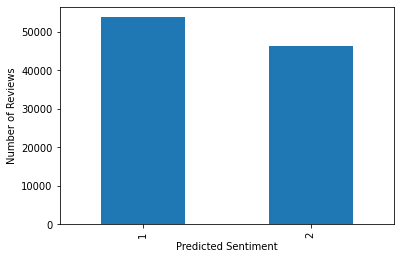

In [42]:
yelp['prediction'].value_counts().plot(kind='bar')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [43]:
correct = (yelp['prediction'] == yelp['sentiment']).sum()
total = yelp.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering:', ratio, '%')

Accuracy of the clustering: 83.9 %


In [44]:
pos = yelp[yelp['sentiment']==2]

correct = (pos['prediction'] == pos['sentiment']).sum()
total = pos.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering:', ratio, '%')

Accuracy of the clustering: 82.17 %


In [45]:
pos = yelp[yelp['sentiment']==1]

correct = (pos['prediction'] == pos['sentiment']).sum()
total = pos.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering:', ratio, '%')

Accuracy of the clustering: 85.42 %


In [19]:
def clean_text(x):
    x = re.sub(r'[^\w\s]', ' ', str(x).lower().strip())

    x = re.sub(r'\s+', ' ', x)

    x = nltk.word_tokenize(x)

    x = [word for word in x if word not in stopwords]


    lem = nltk.stem.wordnet.WordNetLemmatizer()
    x = [lem.lemmatize(token) for token in x]
    
    return " ".join(x)

In [20]:
yelp['cleaned_review'] = yelp['review'].apply(lambda x: clean_text(x))

In [80]:
clean_review_embeddings = bert.encode(yelp['cleaned_review'].tolist())

In [81]:
kmeans = KMeans(n_clusters=2).fit(clean_review_embeddings)
yelp['clean_prediction'] = kmeans.labels_

In [116]:
yelp['clean_prediction'] = yelp['clean_prediction'].replace(0, 2)
yelp['prediction'] = yelp['prediction'].replace(2, 0)
yelp['sentiment'] = yelp['sentiment'].replace(2, 0)

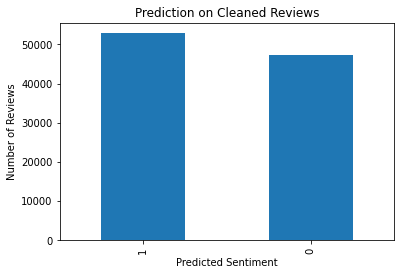

In [83]:
yelp['clean_prediction'].value_counts().plot(kind='bar')
plt.title('Prediction on Cleaned Reviews')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [94]:
correct = (yelp['clean_prediction'] == yelp['sentiment']).sum()
total = yelp.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering with cleaned reviews:', ratio, '%')

Accuracy of the clustering with cleaned reviews: 37.92 %


In [96]:
pos = yelp[yelp['clean_prediction']==2]

correct = (pos['clean_prediction'] == pos['sentiment']).sum()
total = pos.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering with cleaned reviews:', ratio, '%')

Accuracy of the clustering with cleaned reviews: 33.81 %


In [97]:
neg = yelp[yelp['clean_prediction']==1]

correct = (pos['clean_prediction'] == pos['sentiment']).sum()
total = pos.shape[0]

ratio = round(correct / total * 100, 2)

print('Accuracy of the clustering with cleaned reviews:', ratio, '%')

Accuracy of the clustering with cleaned reviews: 33.81 %


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,  roc_auc_score, roc_curve, auc

y_true = yelp['sentiment']
y_pred = yelp['prediction']

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print('Accuracy:', acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Confusion Matrix:')
print(cm)

Accuracy: 0.8389683896838969
Precision: 0.844826624523566
Recall: 0.854180765471088
F1-score: 0.849477944681766
Confusion Matrix:
[[38457  8346]
 [ 7757 45439]]


Text(63.5, 0.5, 'Predicted')

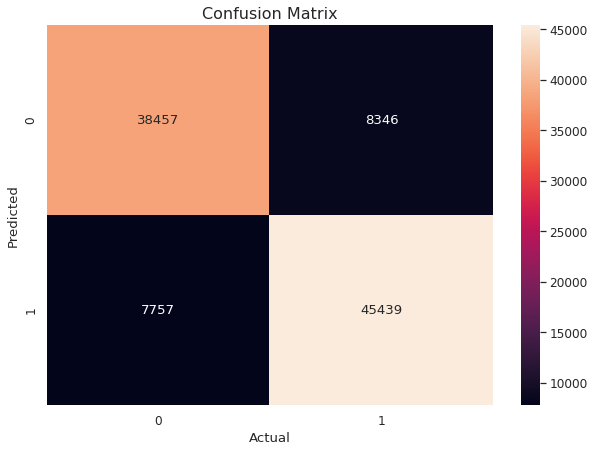

In [137]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,  fmt='g')
plt.title('Confusion Matrix', size=16)
plt.xlabel('Actual')
plt.ylabel('Predicted')

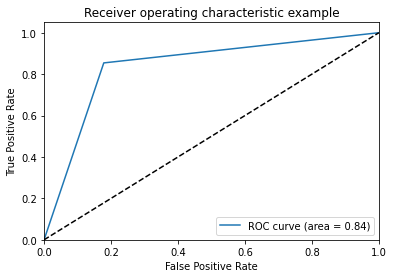

In [61]:
roc_df = yelp

roc_df['sentiment'] = roc_df['sentiment'].replace(2, 0)
roc_df['prediction'] = roc_df['prediction'].replace(2, 0)

y_true2 = roc_df['sentiment']
y_pred2 = roc_df['prediction']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [99]:
# For the cleaned reviews
y_true = yelp['sentiment']
y_pred = yelp['cleanb_prediction']

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print('Accuracy:', acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('Confusion Matrix:')
print(cm)

Accuracy: 0.37922379223792235
Precision: 0.41593623989550005
Recall: 0.4130197759230017
F1-score: 0.41447287750308903
Confusion Matrix:
[[21971 31225]
 [30852 15951]]


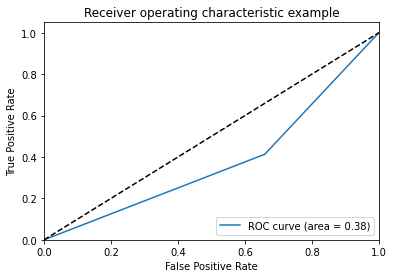

In [100]:
roc_df = yelp

roc_df['sentiment'] = roc_df['sentiment'].replace(2, 0)
roc_df['clean_prediction'] = roc_df['clean_prediction'].replace(2, 0)

y_true2 = roc_df['sentiment']
y_pred2 = roc_df['clean_prediction']

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()